In [254]:
try:
    %tensorflow_version 2.x
except:
    pass

In [255]:
SETUP = True
if SETUP:
    !pip install -q -U toai
    # !pip install -q -U nb_black
    # !pip install -q -U tensorflow-datasets
    !pip install -q  --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

0.3.9
2.1.0


In [256]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
# from toai.image import ImageParser, ImageScaler
import tensorflow as tf
from tensorflow import keras

In [257]:
from typing import *

In [258]:
DATA_DIR = Path("/kaggle/input/pokemon-images-and-types/images/images")

In [313]:
BATCH_SIZE = 32
SHUFFLE_SIZE = 1024
IMG_DIMS = (64, 64, 3)
N_IMAGES = len(os.listdir(DATA_DIR))

In [314]:
import attr

@attr.s(auto_attribs=True)
class ImageParser:
    n_channels: int = 3

    def __call__(self, filename: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        image = tf.image.decode_jpeg(
            tf.io.read_file(filename), channels=self.n_channels
        )
        image = tf.image.convert_image_dtype(image, tf.float32)

        return image, label

In [315]:
@attr.s(auto_attribs=True)
class ImageResizer:
    img_dims: Tuple[int, int, int]
    resize: Optional[str] = None
    crop_adjustment: float = 1

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        height, width, _ = self.img_dims
        if self.resize == "stretch":
            image = tf.image.resize(image, (height, width))
        elif self.resize == "crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(
                images=image, size=(crop_height, crop_width), preserve_aspect_ratio=True
            )
            image = tf.image.resize_with_crop_or_pad(image, height, width)
        elif self.resize == "random_crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(image, (crop_height, crop_width))
            image = tf.image.random_crop(image, self.img_dims)

        return image, label

In [316]:
@attr.s(auto_attribs=True)
class ImageScaler:
    scale_fn: Callable

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        return self.scale_fn(image), label

In [317]:
@tf.function
def preprocess_input(x):
    return x / 255.0

In [318]:
train_data = (
    tf.data.Dataset.from_tensor_slices(([str(x) for x in DATA_DIR.glob('**/*')], os.listdir(DATA_DIR)))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

tf.Tensor(b'charjabug.jpg', shape=(), dtype=string)
0.12380516 1.0


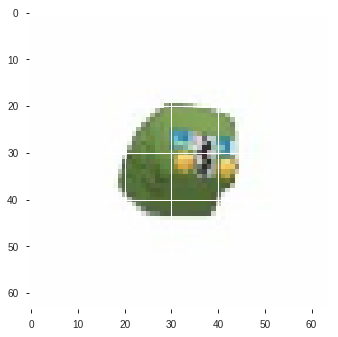

In [319]:
for x, y in train_data.take(1):
    print(y[0])
    print(x[0].numpy().min(), x[0].numpy().max())
    plt.imshow(x.numpy()[0])
    

In [320]:
codings_size = 32

In [321]:
generator = keras.models.Sequential(
    [
        keras.layers.Dense(8 * 8 * 128, input_shape=[codings_size]),
        keras.layers.Reshape([8, 8, 128]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            64,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.activations.selu,
            kernel_initializer=keras.initializers.lecun_uniform(),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            32,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.activations.selu,
            kernel_initializer=keras.initializers.lecun_uniform(),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            IMG_DIMS[2], kernel_size=5, strides=2, padding="SAME", activation=keras.activations.sigmoid
        ),
    ]
)

In [322]:
generator.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 8192)              270336    
_________________________________________________________________
reshape_14 (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (None, 32, 32, 32)        51232     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 32)      

In [323]:
discriminator = keras.models.Sequential(
    [
#         keras.layers.Conv2D(
#             64,
#             kernel_size=5,
#             strides=2,
#             padding="SAME",
#             activation=keras.layers.LeakyReLU(0.2),
#             kernel_initializer=keras.initializers.he_uniform(),
#             input_shape=IMG_DIMS,
#         ),
#         keras.layers.Dropout(0.5),
        keras.layers.Conv2D(
            128,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            kernel_initializer=keras.initializers.he_uniform(),
            input_shape=IMG_DIMS,
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(
            256,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(
            512,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.4),
#         keras.layers.Conv2D(
#             1028,
#             kernel_size=5,
#             strides=2,
#             padding="SAME",
#             activation=keras.layers.LeakyReLU(0.2),
#             kernel_initializer=keras.initializers.he_uniform(),
#         ),
#         keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation=keras.activations.sigmoid),
    ]
)

In [324]:
# discriminator1 = discriminator

In [325]:
# discriminator = keras.models.Sequential([
#     keras.applications.VGG16(include_top=False, weights=None),
#     keras.layers.GlobalMaxPool2D(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1, activation=keras.activations.sigmoid),
# ])

In [326]:
discriminator.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
dropout_70 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
dropout_71 (Dropout)         (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 8, 8, 512)         3277312   
_________________________________________________________________
dropout_72 (Dropout)         (None, 8, 8, 512)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 32768)           

In [327]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [328]:
def train_gan(gan, dataset, n_images, batch_size, codings_size, n_epochs=1):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for train_batch, _ in dataset.take(n_images // batch_size):
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            fake_and_real_data = tf.concat([generated_images, train_batch], axis=0)
            fake_and_real_labels = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(fake_and_real_data, fake_and_real_labels)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            noise_labels = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, noise_labels)
        plot_multiple_images(generated_images, 8)
        plt.show()

In [329]:
gan = keras.models.Sequential([generator, discriminator])

In [298]:
# discriminator.compile(
#     loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(3e-4)
# )
# discriminator.trainable = False
# gan.compile(
#     loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(1e-4)
# )

In [ ]:
discriminator.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(3e-4)
)
discriminator.trainable = False
gan.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(3e-3)
)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 20)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 20)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 20)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 10)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 10)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 10)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 100)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 20)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 100)

In [ ]:
BATCH_SIZE = 64
SHUFFLE_SIZE = 1024
IMG_DIMS = (64, 64, 3)
N_IMAGES = len(os.listdir(DATA_DIR))

In [ ]:
codings_size = 256

In [ ]:
generator = keras.models.Sequential(
    [
        keras.layers.Dense(8 * 8 * 256, input_shape=[codings_size]),
        keras.layers.Reshape([8, 8, 256]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            256,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.activations.selu,
            kernel_initializer=keras.initializers.lecun_uniform(),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            128,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.activations.selu,
            kernel_initializer=keras.initializers.lecun_uniform(),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            IMG_DIMS[2], kernel_size=5, strides=2, padding="SAME", activation=keras.activations.sigmoid
        ),
    ]
)

In [ ]:
generator.summary()

In [ ]:
discriminator = keras.models.Sequential(
    [
        keras.layers.Conv2D(
            128,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            kernel_initializer=keras.initializers.he_uniform(),
            input_shape=IMG_DIMS,
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(
            256,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(
            512,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(
            1024,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation=keras.activations.sigmoid),
    ]
)

In [ ]:
# discriminator1 = discriminator

In [ ]:
# discriminator = keras.models.Sequential([
#     keras.applications.VGG16(include_top=False, weights=None),
#     keras.layers.GlobalMaxPool2D(),
#     keras.layers.Dropout(0.4),
#     keras.layers.Dense(1, activation=keras.activations.sigmoid),
# ])

In [ ]:
discriminator.summary()

In [ ]:
def train_gan(gan, dataset, n_images, batch_size, codings_size, n_epochs=1):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for train_batch, _ in dataset.take(n_images // batch_size):
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            fake_and_real_data = tf.concat([generated_images, train_batch], axis=0)
            fake_and_real_labels = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(fake_and_real_data, fake_and_real_labels)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            noise_labels = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, noise_labels)
        plot_multiple_images(generated_images, 10)
        plt.show()

In [ ]:
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(2e-4)
)
discriminator.trainable = False
gan.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(2e-4)
)

In [ ]:
train_gan(gan, train_data, N_IMAGES, BATCH_SIZE, codings_size, 100)